In [12]:
# importing required libraries
import math
import copy
import numpy as np

# torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch.optim as optim
import torch.utils.data as data

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
torchtext.disable_torchtext_deprecation_warning()

## The Embedding Layer
The embedding layer provides each token in a corpus with a corresponding vector representation. This is the first layer that each sequence must be passed through. Each token in each sequence has to be embedded in a vector with a length of d_model. The input into this layer is (batch_size, seq_length). The output is (batch_size, seq_length, d_model).

In [13]:
class Embeddings(nn.Module):
    def __init__(self, vocab_size, d_model):
        """
        Args:
          vocab_size:     size of vocabulary
          d_model:        dimension of embeddings
        """
        # inherit from nn.Module
        super().__init__()

        # embedding look-up table
        self.lut = nn.Embedding(vocab_size, d_model)

        # dimension of embeddings
        self.d_model = d_model

    def forward(self, x: Tensor):
        """
        Args:
          x:              input Tensor (batch_size, seq_length)
        Returns:
                          embedding vector
        """
        # embeddings by constant sqrt(d_model)
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encodong
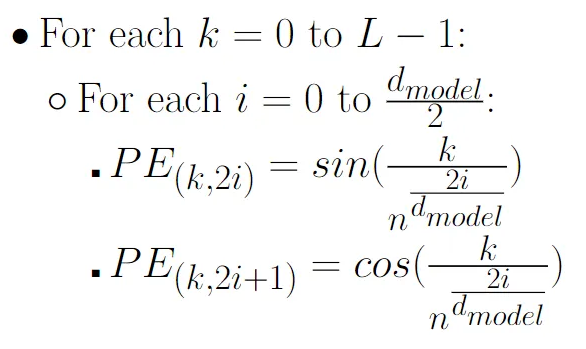

These embedded sequences are then positionally encoded to provide additional context to each word. This also allows for a single word to have varying meanings depending on its placement in the sentence. The input to the layer is (batch_size, seq_length, d_model). The positional encoding matrix, with a size of (max_length, d_model), must be sliced to the same length as each sequence in the batch, giving it a size of (seq_length, d_model). This same matrix is broadcast and added to each sequence in the batch to ensure consistency. The final output is (batch_size, seq_length, d_model).

In [14]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout, max_length):
        """
        Args:
          d_model:      dimension of embeddings
          dropout:      randomly zeroes-out some of the input
          max_length:   max sequence length
        """
        # inherit from Module
        super().__init__()

        # initialize dropout
        self.dropout = nn.Dropout(p=dropout)

        # create tensor of 0s
        pe = torch.zeros(max_length, d_model)

        # create position column
        k = torch.arange(0, max_length).unsqueeze(1)

        # calc divisor for positional encoding
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

        # calc sine on even indices
        pe[:, 0::2] = torch.sin(k * div_term)

        # calc cosine on odd indices
        pe[:, 1::2] = torch.cos(k * div_term)

        # add dimension
        pe = pe.unsqueeze(0)

        # buffer are saved in state_dict but not trained by the optimizer
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor):
        """
        Args:
          x:        embeddings (batch_size, seq_length, d_model)

        Returns:
                    embeddings + positional encodings (batch_size, seq_length, d_model)
        """
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)

        # perform dropout
        return self.dropout(x)


## Multi-Head Attention

Three identical versions of these embedded and encoded sequences are passed to the multi-head attention layer to create unique query, key, and value tensors that are transformed by linear layers. They all have a size of (batch_size, seq_length, d_model), where seq_length varies based on the respective length of each sequence. These tensors are split into their respective number of heads, taking a size of (batch_size, n_heads, seq_length, d_key), where d_key = (d_model / n_heads). Each sequence now has n_heads representations that can attend to different aspects of the sequence during training.

The query and key tensors are multiplied by each other to generate a probability distribution, and they are divided by √(d_key). The key tensor has to be transposed. The output of the multiplication represents each sequence’s relationship to itself, and it represents the target sequence’s relationship to the source sequence in the second attention mechanism of the decoder. These distributions have a size of (batch_size, n_heads, Q_length, K_length). They are masked depending on the padding of the sequences, or if they are in the first attention-mechanism of the decoder, they are also masked to allow the sequence to only attend to previous tokens, which is the autoregressive property of the decoder.

These probabilities are multiplied by another representation of the sequence, which is the values tensor. In the decoder’s second attention mechanism, it is the source sequence again. The values tensor has a shape of (batch_size, n_heads, V_length, d_key). The output of the multiplication is (batch_size, n_heads, Q_length, d_key). The two tensors are multiplied together to reweight the values tensor by calculating a summary of the most important contexts for each token in each head or subspace.

This output from the attention mechanism is concatenated back to its original shape, (batch_size, seq_length, d_model), where seq_length = Q_length. Finally, this tensor is passed through a linear layer with a shape of (d_model, d_model) that is broadcast across each sequence. The final output is (batch_size, seq_length, d_model).

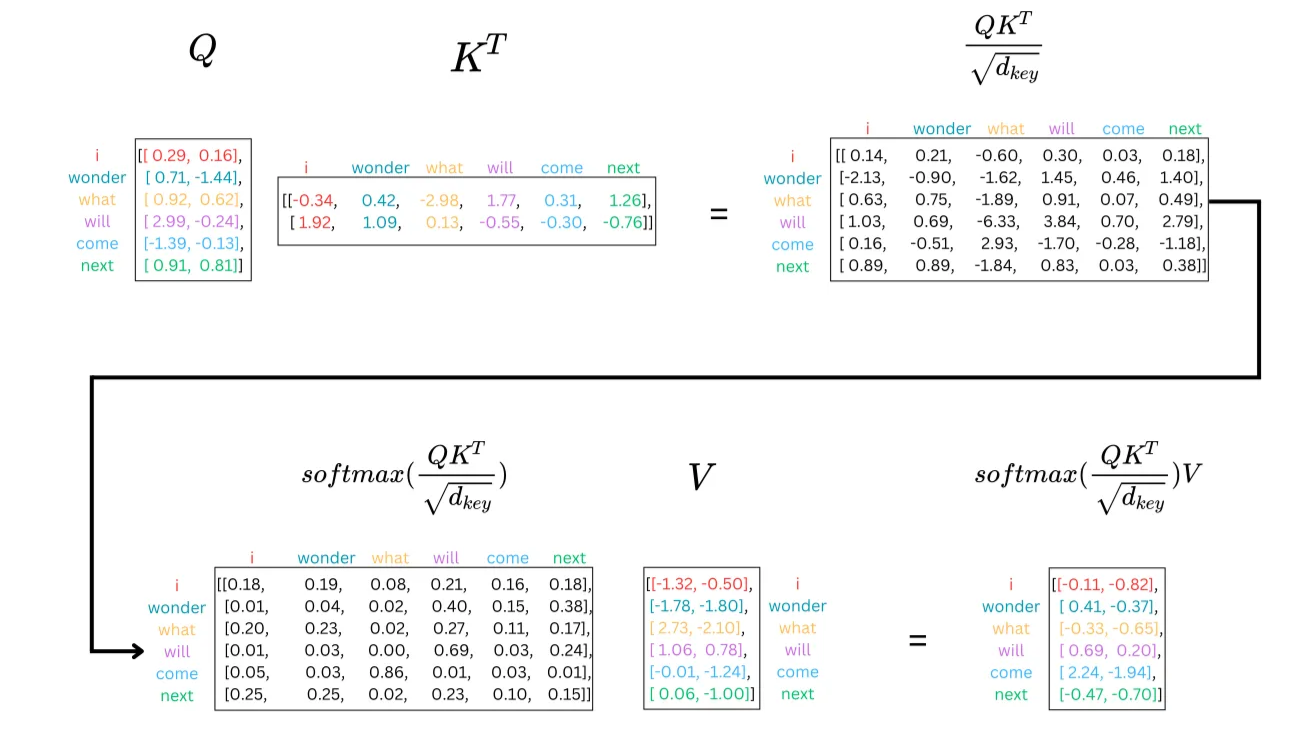

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        """
        Args:
            d_model:      dimension of embeddings
            n_heads:      number of self attention heads
            dropout:      probability of dropout occurring
        """
        super().__init__()
        assert d_model % n_heads == 0  # ensure an even num of heads
        self.d_model = d_model  # 512 dim
        self.n_heads = n_heads  # 8 heads
        self.d_key = d_model // n_heads  # assume d_value equals d_key

        self.Wq = nn.Linear(d_model, d_model)  # query weights
        self.Wk = nn.Linear(d_model, d_model)  # key weights
        self.Wv = nn.Linear(d_model, d_model)  # value weights
        self.Wo = nn.Linear(d_model, d_model)  # output weights

        self.dropout = nn.Dropout(p=dropout)  # initialize dropout layer

    def forward(self, query: Tensor, key: Tensor, value: Tensor, mask: Tensor = None):
        """
        Args:
           query:         query vector         (batch_size, q_length, d_model)
           key:           key vector           (batch_size, k_length, d_model)
           value:         value vector         (batch_size, s_length, d_model)
           mask:          mask for decoder

        Returns:
           output:        attention values     (batch_size, q_length, d_model)
           attn_probs:    softmax scores       (batch_size, n_heads, q_length, k_length)
        """
        assert isinstance(key, torch.Tensor), "Expected key to be a tensor"
        assert isinstance(query, torch.Tensor), "Expected query to be a tensor"
        assert isinstance(value, torch.Tensor), "Expected value to be a tensor"

        batch_size = key.size(0)

        # calculate query, key, and value tensors
        Q = self.Wq(query)  # (32, 10, 512) x (512, 512) = (32, 10, 512)
        K = self.Wk(key)  # (32, 10, 512) x (512, 512) = (32, 10, 512)
        V = self.Wv(value)  # (32, 10, 512) x (512, 512) = (32, 10, 512)

        # split each tensor into n-heads to compute attention

        # query tensor
        Q = Q.view(batch_size, -1, self.n_heads, self.d_key).permute(0, 2, 1, 3)
        # (32, 10, 8, 64) -> (32, 8, 10, 64) = (batch_size, n_heads, q_length, d_key)

        # key tensor
        K = K.view(batch_size, -1, self.n_heads, self.d_key).permute(0, 2, 1, 3)
        # (32, 10, 8, 64) -> (32, 8, 10, 64) = (batch_size, n_heads, k_length, d_key)

        # value tensor
        V = V.view(batch_size, -1, self.n_heads, self.d_key).permute(0, 2, 1, 3)
        # (32, 10, 8, 64) -> (32, 8, 10, 64) = (batch_size, n_heads, v_length, d_key)

        # computes attention
        # scaled dot product -> QK^{T}
        scaled_dot_prod = torch.matmul(Q, K.permute(0, 1, 3, 2)) / math.sqrt(self.d_key)
        # (32, 8, 10, 64) x (32, 8, 64, 10) -> (32, 8, 10, 10) = (batch_size, n_heads, q_length, k_length)

        # fill those positions of product as (-1e10) where mask positions are 0
        if mask is not None:
            scaled_dot_prod = scaled_dot_prod.masked_fill(mask == 0, -1e10)

        # apply softmax
        attn_probs = torch.softmax(scaled_dot_prod, dim=-1)

        # multiply by values to get attention
        A = torch.matmul(self.dropout(attn_probs), V)  # (32, 8, 10, 10) x (32, 8, 10, 64) -> (32, 8, 10, 64)
        # (batch_size, n_heads, q_length, k_length) x (batch_size, n_heads, v_length, d_key) -> (batch_size, n_heads, q_length, d_key)

        # reshape attention back to (32, 10, 512)
        A = A.permute(0, 2, 1, 3).contiguous()
        # (32, 8, 10, 64) -> (32, 10, 8, 64)

        A = A.view(batch_size, -1, self.n_heads * self.d_key)
        # (32, 10, 8, 64) -> (32, 10, 8*64) -> (32, 10, 512) = (batch_size, q_length, d_model)

        # push through the final weight layer
        output = self.Wo(A)  # (32, 10, 512) x (512, 512) = (32, 10, 512)

        return output, attn_probs  # return attn_probs for visualization of the scores


## Position-Wise Feed-Forward Network

After being passed through layer normalization and undergoing residual addition, the output from the attention mechanism is passed to the FFN. The FFN consists of two linear layers with a ReLU activation function. The first layer has a shape of (d_model, d_ffn). This is broadcast across each sequence of the (batch_size, seq_length, d_model) tensor, and it allows the model to learn more about each sequence. The tensor has a shape of (batch_size, seq_length, d_ffn) at this point, and it is passed through ReLU. Then, it is passed through the second layer, which has a shape of (d_ffn, d_model). This contracts the tensor to its original size, (batch_size, seq_length, d_model). The outputs are passed through layer normalization and undergo residual addition.

In [16]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        """
        Args:
            d_model:      dimension of embeddings
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x:            output from attention (batch_size, seq_length, d_model)

        Returns:
            expanded-and-contracted representation (batch_size, seq_length, d_model)
        """
        # w_1(x).relu(): (batch_size, seq_length, d_model) x (d_model,d_ffn) -> (batch_size, seq_length, d_ffn)
        # w_2(w_1(x).relu()): (batch_size, seq_length, d_ffn) x (d_ffn, d_model) -> (batch_size, seq_length, d_model)
        return self.linear2(self.dropout(F.relu(self.linear1(x))))


## Layer Normalization
  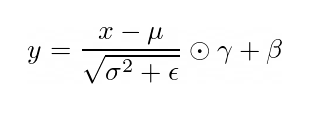



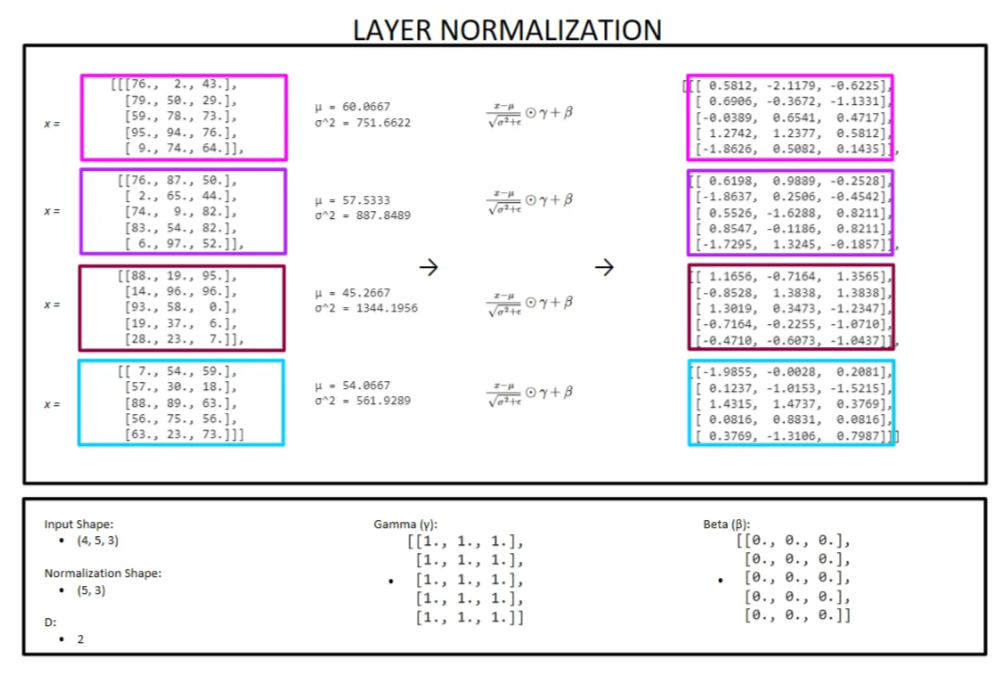

In [17]:
class LayerNorm(nn.Module):
    def __init__(self,feature, eps = 1e-5):
        super().__init__()
        # initialize gamma to be all ones
        self.gamma = nn.Parameter(torch.ones(feature))
        # initialize beta to be all zeros
        self.beta = nn.Parameter(torch.zeros(feature))
        # initialize epsilon
        self.eps = eps

    def forward(self, src):
        # mean of the token embeddings
        mean = src.mean(-1, keepdim=True)
        # variance of the token embeddings  
        var = src.var(-1,keepdim=True,unbiased=False)
        # return the normalized value 
        return self.gamma*(src - mean)/torch.sqrt(var + self.eps)+self.beta     

## The Encoder

Each encoder layer includes all of the aforementioned layers. It is responsible for enriching the embeddings of the source sequences. The input has a size of (batch_size, seq_length, d_model). The embedded sequences are passed directly to the multi-head attention mechanism. After being passed through Nx layers in the Encoder stack, the output is an enriched representation of each sequence that contains as much context as possible. It has a size of (batch_size, seq_length, d_model).

In [18]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, n_heads, d_ff, dropout):
        """
        Args:
            d_model:      dimension of embeddings
            n_heads:      number of heads
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()
        # multi-head attention sublayer
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        # layer norm for multi-head attention
        self.attn_layer_norm = nn.LayerNorm(d_model)

        # position-wise feed-forward network
        self.positionwise_ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        # layer norm for position-wise ffn
        self.ffn_layer_norm = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src: Tensor, src_mask: Tensor):
        """
        Args:
            src:          positionally embedded sequences   (batch_size, seq_length, d_model)
            src_mask:     mask for the sequences            (batch_size, 1, 1, seq_length)
        Returns:
            src:          sequences after self-attention    (batch_size, seq_length, d_model)
        """
        # pass embeddings through multi-head attention
        _src, attn_probs = self.attention(src, src, src, src_mask)

        # residual add and norm
        src = self.attn_layer_norm(src + self.dropout(_src))

        # position-wise feed-forward network
        _src = self.positionwise_ffn(src)

        # residual add and norm
        src = self.ffn_layer_norm(src + self.dropout(_src))
        return src, attn_probs


## The Decoder

Each decoder layer has two responsibilities: (1) to learn the autoregressive representation of the shifted target sequence and (2) to learn how the target sequence relates to the enriched embeddings from the Encoder. Like the Encoder, a Decoder stack has Nx decoder layers. As mentioned before, the Encoder output is passed to each decoder layer.

The input to the first decoder layer is shifted right, and it is embedded and encoded. It has a shape of (batch_size, seq_length, d_model). It is passed through the first attention mechanism, where the model learns an autoregressive representation of the sequence with itself. The output of this mechanism retains its shape, and it is passed to the second attention mechanism. It is multiplied against the encoder’s enriched embeddings, and the output once again retains its original shape.

After being passed through the FFN, the tensor is passed through a final linear layer that has a shape of (d_model, vocab_size). This creates a tensor with a size of (batch_size, seq_length, vocab_size). These are the logits for the sequence. These logits can be passed through a softmax function, and the highest probability is the prediction for each token.

In [19]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ffn: int, dropout: float):
        """
        Args:
            d_model:      dimension of embeddings
            n_heads:      number of heads
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()
        # masked multi-head attention sublayer
        self.masked_attention = MultiHeadAttention(d_model, n_heads, dropout)
        # layer norm for masked multi-head attention
        self.masked_attn_layer_norm = nn.LayerNorm(d_model)

        # multi-head attention sublayer
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        # layer norm for multi-head attention
        self.attn_layer_norm = nn.LayerNorm(d_model)

        # position-wise feed-forward network
        self.positionwise_ffn = PositionwiseFeedForward(d_model, d_ffn, dropout)
        # layer norm for position-wise fnn
        self.fnn_layer_norm = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, trg: Tensor, src: Tensor, trg_mask: Tensor, src_mask: Tensor):
        """
        Args:
            trg:          embedded sequences                (batch_size, trg_seq_length, d_model)
            src:          embedded sequences                (batch_size, src_seq_length, d_model)
            trg_mask:     mask for the sequences            (batch_size, 1, trg_seq_length, trg_seq_length)
            src_mask:     mask for the sequences            (batch_size, 1, 1, src_seq_length)

        Returns:
            trg:          sequences after self-attention    (batch_size, trg_seq_length, d_model)
            attn_probs:   self-attention softmax scores     (batch_size, n_heads, trg_seq_length, src_seq_length)
        """
        # pass trg embeddings through masked multi-head attention
        _trg, attn_probs = self.masked_attention(trg, trg, trg, trg_mask)

        # residual add and norm
        trg = self.masked_attn_layer_norm(trg + self.dropout(_trg))

        # pass trg and src embeddings multi-head attention
        _trg, attn_probs = self.attention(trg, src, src, src_mask)

        # residual add and norm
        trg = self.attn_layer_norm(trg + self.dropout(_trg))

        # position-wise feed-forward network
        _trg = self.positionwise_ffn(trg)

        # residual add and norm
        trg = self.fnn_layer_norm(trg + self.dropout(_trg))
        return trg, attn_probs


## Transformer

The Encoder and Decoder can be combined in a module to create the Transformer model. The module can be initialized with an Encoder, Decoder, and the target and source embeddings.

The forward pass requires the source sequences and shifted target sequences. The sources are embedded and passed through the Encoder. The output and embedded target sequences are passed through the Decoder. The functions to create the source and target masks are also part of the module.

The logits are the output of the model. The tensor has a size of (batch_size, seq_length, vocab_size).
Encoder, Decoder, positional encodings, and embeddings. Then, it passes these into the Transformer module to create a model that can be trained. In the last article, these steps were performed on their own, which is an acceptable alternative.

In [20]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super().__init__()
        self.encoder_embeddings = Embeddings(src_vocab_size, d_model)
        self.decoder_embeddings = Embeddings(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout, max_seq_length)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for layer in range(num_layers)])
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for layer in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def make_mask(self, src, tgt):
        # assign 1 to tokens that need attended to and 0 to padding tokens, then add 2 dimensions
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        # src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # assign True to tokens that need attended to and False to padding tokens, then add 2 dimensions
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)

        # generate subsequent mask
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length, device=device), diagonal=1)).bool()

        # bitwise "and" operator | 0 & 0 = 0, 1 & 1 = 1, 1 & 0 = 0
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):

        # create source and target masks
        src_mask, tgt_mask = self.make_mask(src, tgt)

        # push the src through the encoder layers
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embeddings(src)))

        # decoder output and attention probabilities
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embeddings(tgt)))

        # pass the sequences through each encoder
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output,_ = enc_layer(enc_output, src_mask)

        # pass the sequences through each decoder
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output,_ = dec_layer(dec_output, enc_output, tgt_mask, src_mask)

        # set output layer
        output = self.fc(dec_output)
        return output

In [21]:
random_seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Loading Data

In [22]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from functools import partial
import math
import time

# Set random seed and device
random_seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
data_path = 'spa.txt'
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

lines[100]

'Got it?\t¿Entendiste?\tCC-BY 2.0 (France) Attribution: tatoeba.org #455353 (CM) & #989540 (hayastan)\n'

In [23]:
# Preprocess data
lines = [line.split('\t') for line in lines]
lines = ['\t'.join(line[:2]) for line in lines]

# Create train, val, test split
train_lines, val_test_lines = train_test_split(lines, test_size=0.2, random_state=random_seed, shuffle=True)
val_lines, test_lines = train_test_split(val_test_lines, test_size=0.5, random_state=random_seed, shuffle=True)

train_lines[100]

"I've heard that from a lot of people.\tHe oído eso de mucha gente."

In [24]:
# Tokenizers
SRC_LANGUAGE = "en"
TGT_LANGUAGE = "es"
tokenizer = {
    SRC_LANGUAGE: get_tokenizer("spacy", "en_core_web_sm"),
    TGT_LANGUAGE: get_tokenizer("spacy", "es_core_news_sm")
}


# Tokenize lines
def tokenize_lines(lines, src_tokenizer, tgt_tokenizer):
    tokenized_lines = []
    for line in lines:
        src, tgt = line.split('\t')
        src_tokens = src_tokenizer(src)
        tgt_tokens = tgt_tokenizer(tgt)
        tokenized_lines.append((src_tokens, tgt_tokens))
    return tokenized_lines


train_data = tokenize_lines(train_lines, tokenizer[SRC_LANGUAGE], tokenizer[TGT_LANGUAGE])
val_data = tokenize_lines(val_lines, tokenizer[SRC_LANGUAGE], tokenizer[TGT_LANGUAGE])
test_data = tokenize_lines(test_lines, tokenizer[SRC_LANGUAGE], tokenizer[TGT_LANGUAGE])

train_data[100]

(['I', "'ve", 'heard', 'that', 'from', 'a', 'lot', 'of', 'people', '.'],
 ['He', 'oído', 'eso', 'de', 'mucha', 'gente', '.'])

In [25]:
# Build vocabularies
special_symbols = ['<PAD>', '<UNK>', '<BOS>', '<EOS>']
src_vocab_size = 10_000
tgt_vocab_size = 10_000


def yield_tokens(data, lang_idx):
    for tokens in data:
        yield tokens[lang_idx]


vocab = {}
vocab[SRC_LANGUAGE] = build_vocab_from_iterator(yield_tokens(train_data, lang_idx=0), min_freq=1,
                                                specials=special_symbols, special_first=True, max_tokens=src_vocab_size)
vocab[TGT_LANGUAGE] = build_vocab_from_iterator(yield_tokens(train_data, lang_idx=1), min_freq=1,
                                                specials=special_symbols, special_first=True, max_tokens=tgt_vocab_size)
vocab[SRC_LANGUAGE].set_default_index(1)  # UNK_IDX
vocab[TGT_LANGUAGE].set_default_index(1)  # UNK_IDX

# Define collate function
PAD_IDX = 0
BOS_IDX = 2
EOS_IDX = 3
max_seq_len = 100


def collate_fn(batch, vocab):
    batch_size = len(batch)
    srcs, tgts = zip(*batch)
    src_vectors = torch.zeros((batch_size, max_seq_len), dtype=torch.long, device=device)
    tgt_vectors = torch.zeros((batch_size, max_seq_len), dtype=torch.long, device=device)

    for i in range(batch_size):
        src_indices = [BOS_IDX] + [vocab[SRC_LANGUAGE][token] for token in srcs[i]] + [EOS_IDX]
        tgt_indices = [BOS_IDX] + [vocab[TGT_LANGUAGE][token] for token in tgts[i]] + [EOS_IDX]
        src_len = len(src_indices)
        tgt_len = len(tgt_indices)
        src_vectors[i, :src_len] = torch.tensor(src_indices[:max_seq_len], dtype=torch.long)
        tgt_vectors[i, :tgt_len] = torch.tensor(tgt_indices[:max_seq_len], dtype=torch.long)

    return src_vectors, tgt_vectors


# Create DataLoaders
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=partial(collate_fn, vocab=vocab))
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True, collate_fn=partial(collate_fn, vocab=vocab))
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True, collate_fn=partial(collate_fn, vocab=vocab))



## Training

In [ ]:
from torch.cuda.amp import GradScaler, autocast

from torch.cuda.amp import GradScaler, autocast


def calculate_accuracy(output, target, pad_idx):
    output_flat = output.argmax(dim=-1).reshape(-1)
    target_flat = target.reshape(-1)
    non_pad_elements = target_flat != pad_idx
    correct = output_flat.eq(target_flat) & non_pad_elements
    accuracy = correct.sum().float() / non_pad_elements.sum().float()
    return accuracy.item()


src_vocab_size = 10_000
tgt_vocab_size = 10_000
d_model = 256
num_heads = 4
num_layers = 4
d_ff = 1024
max_seq_length = 100
dropout = 0.1
num_epochs = 3
pad_idx = 0

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length,
                          dropout).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scaler = GradScaler()

for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}\n------------------------------")
    transformer.train()
    epoch_loss = 0
    epoch_accuracy = 0
    batch_count = 0

    for data in train_dataloader:
        src_data, tgt_data = data
        optimizer.zero_grad()
        with autocast():
            output = transformer(src_data, tgt_data[:, :-1])
            loss = criterion(output.contiguous().reshape(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().reshape(-1))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        accuracy = calculate_accuracy(output, tgt_data[:, 1:], pad_idx)
        epoch_accuracy += accuracy
        batch_count += 1
        print(f"Batch: {batch_count}, Training Loss: {loss.item()}, Training Accuracy: {accuracy}")

        torch.cuda.empty_cache()

    print(
        f"Epoch: {epoch + 1}, Average Training Loss: {epoch_loss / batch_count}, Average Training Accuracy: {epoch_accuracy / batch_count}")

    transformer.eval()
    epoch_val_loss = 0
    epoch_val_accuracy = 0
    batch_count = 0
    with torch.no_grad():
        for data in val_dataloader:
            src_data, tgt_data = data
            with autocast():
                output = transformer(src_data, tgt_data[:, :-1])
                loss = criterion(output.contiguous().reshape(-1, tgt_vocab_size),
                                 tgt_data[:, 1:].contiguous().reshape(-1))

            epoch_val_loss += loss.item()
            accuracy = calculate_accuracy(output, tgt_data[:, 1:], pad_idx)
            epoch_val_accuracy += accuracy
            batch_count += 1
            print(f"Batch: {batch_count}, Validation Loss: {loss.item()}, Validation Accuracy: {accuracy}")

    print(
        f"Epoch: {epoch + 1}, Average Validation Loss: {epoch_val_loss / batch_count}, Average Validation Accuracy: {epoch_val_accuracy / batch_count}")

    torch.save(transformer.state_dict(), f'./transformer_state_dict_epoch_{epoch + 1}')

In [ ]:
transformer.eval()
with torch.no_grad():
    for data in test_dataloader:
        src_data, tgt_data = data
        output = transformer(src_data, tgt_data[:, :-1])
        loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
        print(f"Test Loss: {loss.item()}")

## Translation

In [ ]:
model_path = "./transformer_epoch_3"
state_dict = torch.load(model_path)

src_vocab_size = 10_000
tgt_vocab_size = 10_000
d_model = 512
num_heads = 4
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1
num_epochs = 3

transformer_loaded = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout).to(device)
transformer_loaded.load_state_dict(state_dict)


In [ ]:
def translate(src):
    src_tokens = tokenizer[SRC_LANGUAGE](src)
    tgt_tokens = [""]

    src_vectors = torch.tensor(([BOS_IDX] + vocab[SRC_LANGUAGE](src_tokens) + [EOS_IDX] + [0] * (max_seq_len - len(src_tokens)))[:max_seq_len], dtype=torch.long, device=device).unsqueeze(0)

    for i in range(max_seq_len):
        tgt_vectors = torch.tensor((vocab[TGT_LANGUAGE](tgt_tokens) + [0] * (max_seq_len - len(tgt_tokens)))[:max_seq_len], dtype=torch.long, device=device).unsqueeze(0)
        output = transformer(src_vectors, tgt_vectors)
        idx = torch.argmax(nn.functional.softmax(output, dim=2)[0][i]).item()
        tgt_tokens.append(vocab[TGT_LANGUAGE].lookup_token(idx))

        if idx == EOS_IDX:
            break

    return " ".join(tgt_tokens).replace("", "").replace("", "").replace("", "").strip()

In [ ]:
translate("Hello, I am a teacher.")

In [ ]:
translate("My name is John.")

In [ ]:

translate("I am learning Spanish.")